### Load/Clean data
1. Status column has ['Complete','Disqualified','Partial']
2. To be considered Complete the following 3 questions must be answered

 - Which of these statements best describes your current perception of the organisation as an employer
 - On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?
 - Which of these factors would most motivate you to apply for a position at the organisation?

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


data_path = '/content/drive/MyDrive/sds_datathon_gradsingapore.xlsx'

#leave o_df alone
o_df=pd.read_excel(data_path)

#apply all cleaning operations in df
df=o_df.copy()

print(len(o_df),'rows')



2614 rows


In [ ]:
#got quite a bit of missing values
o_df.isna().sum()

,0
Response ID,0
Time Started,0
Date Submitted,0
Status,0
Language,0
SessionID,0
User Agent,0
Tags,2614
IP Address,0
Longitude,16


In [ ]:
o_df['Status'].value_counts()

,count
Status,
Complete,1848
Disqualified,465
Partial,301


In [ ]:
#cleaning
def extract_device(user_agent):
  if pd.isna(user_agent):
    return 'Unknown'
  ua = str(user_agent).lower()

  if 'iphone' in ua or 'android' in ua or 'ipad' in ua:
    return 'Mobile'
  elif 'windows' in ua or 'macintosh' in ua or 'linux':
    return 'Desktop'
  else:
    return 'Other'
#got white space at end of the columns
df.columns=df.columns.str.strip()

#simpler column names
column_mapping = {
    'Which higher education institution do you or did you study at?': 'Institution',
    'What is your current year of study as of 2025?': 'Year_of_Study',
    'What will be your highest qualification when you graduate?': 'Qualification',
    'Which of the following best describes the main subject that you are studying?': 'Subject',
    'Please indicate your nationality.': 'Nationality',
    'What is your gender?': 'Gender',
    'Which of these statements best describes your current perception of the organisation as an employer?': 'Perception', #evaluates your existing impression and understanding based on what you already know. (retrospective and evaluative)
    'On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?': 'Attractiveness_Rating',
    'Which of these factors would most motivate you to apply for a position at the organisation?': 'Motivation_Factor', #targets existing attraction and drivers—what has already convinced you this role is worth pursuing
}


discipline_mapping = {
    'Natural Science (Physics, Chemistry, Biology, Earth Sciences, etc.)': 'STEM & Quantitative Sciences',
    'Mathematical Science/Statistics': 'STEM & Quantitative Sciences',
    'Engineering (Electrical/Electronics, Mechanical, Civil, Chemical, Industrial Engineering, etc.)': 'STEM & Quantitative Sciences',
    'IT and Technology': 'STEM & Quantitative Sciences',
    'Geography and Environmental Science': 'STEM & Quantitative Sciences',
    'Agriculture, Veterinary Science and related subjects': 'STEM & Quantitative Sciences',
    'Medicine, Dentistry and related subjects': 'Health Sciences',
    'Psychology': 'Health Sciences',
    'Business/Management (Accounting, Finance, Marketing, Management, etc.)': 'Business & Economics',
    'Economics': 'Business & Economics',
    'Social Science': 'Social Sciences & Humanities',
    'Historical/Philosophical Science': 'Social Sciences & Humanities',
    'Politics': 'Social Sciences & Humanities',
    'Law': 'Social Sciences & Humanities',
    'Creative Arts and Design': 'Arts, Design & Built Environment',
    'Architecture, Building and Planning': 'Arts, Design & Built Environment',
    'English': 'Language & Communication',
    'Languages, Literature and Classics': 'Language & Communication',
    'Media': 'Language & Communication',
    'Education/Teaching': 'Education'
}

#rename columns
df = df.rename(columns=column_mapping)

#map subjects into categories
df['Subject']=df['Subject'].map(discipline_mapping)


#extract user agent
df['User Agent']=df['User Agent'].apply(extract_device)



### Data Overview
1. Data Summary
2. Response Quality
3. Key Demographics
4. Survey Variables
5. Data Quality Notes

 1. Data Summary

In [ ]:
#data summary
print(len(df), 'rows')
print(len(df.columns),'columns')
print(df['Institution'].nunique(), 'unique institutes from NUS,NTU,SMU to private universites like James Cook University,PSB Academy,Kaplan Singapore')




2614 rows
32 columns
25 unique institutes from NUS,NTU,SMU to private universites like James Cook University,PSB Academy,Kaplan Singapore


2. Response Quality

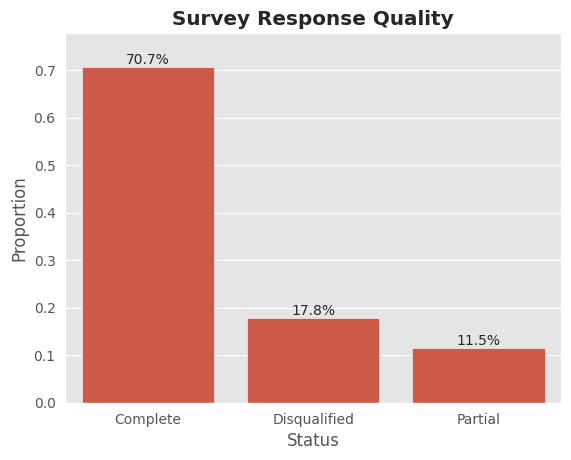

In [ ]:
#survey, status column has no NULLs
counts = (df['Status'].value_counts(normalize=True).reset_index())
counts.columns = ['Status', 'proportion']
ax = sns.barplot(data=counts, x='Status', y='proportion')

# Add percentage labels
for p in ax.patches:
    percentage = f"{p.get_height() * 100:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.ylabel("Proportion")
plt.ylim(0, counts['proportion'].max() * 1.1)
plt.title('Survey Response Quality')
plt.show()

3. Key Demographics (all distrubution)

Institution Distrubution

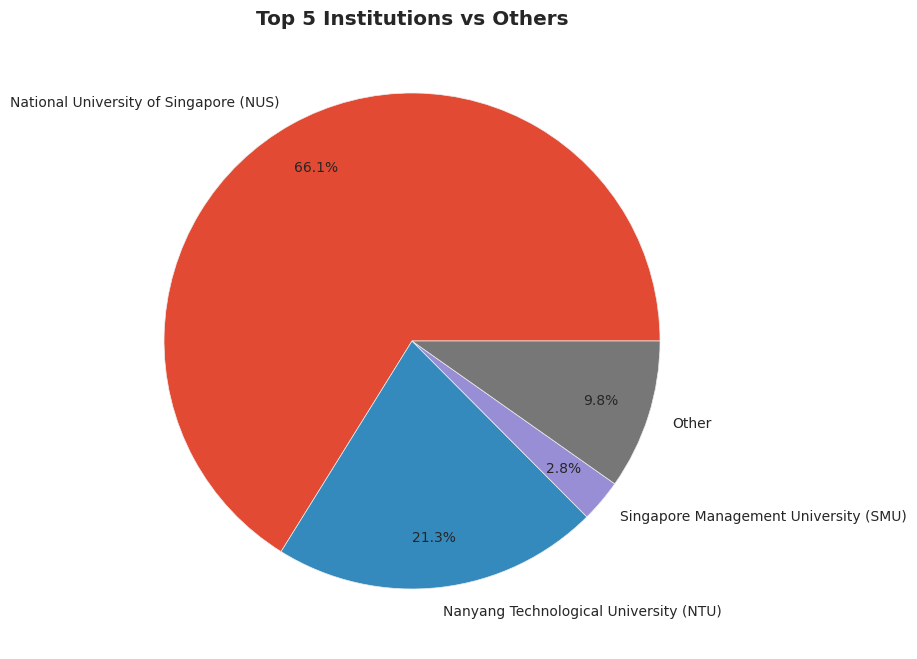

In [ ]:
counts = df['Institution'].value_counts()
top5 = counts[:3]


others = counts[3:].sum()

final_counts = top5.copy()
final_counts['Other'] = others

plt.figure(figsize=(8, 8))
plt.title('Top 5 Institutions vs Others')
plt.axis('equal')
plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', pctdistance=0.8)

plt.show()


 Gender Distribution

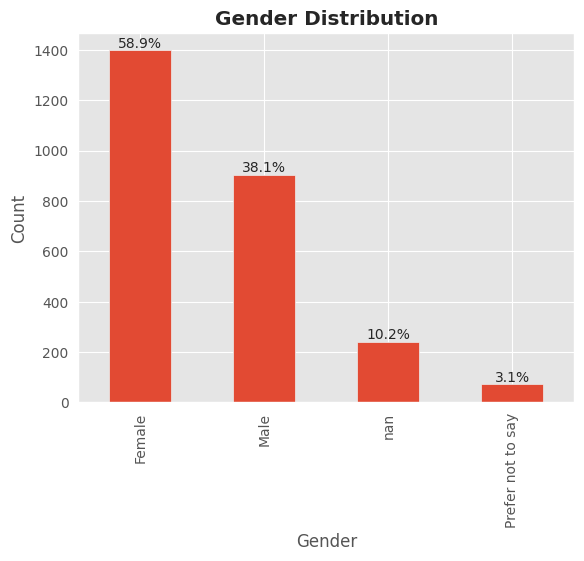

In [ ]:
#Gender Distribution
ax = df['Gender'].value_counts(dropna=False).sort_values(ascending=False).plot(kind='bar')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Add percentage labels
total =  df['Gender'].value_counts().sum()
for p in ax.patches:
    percentage = (p.get_height() / total) * 100
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

Nationality Distrubution

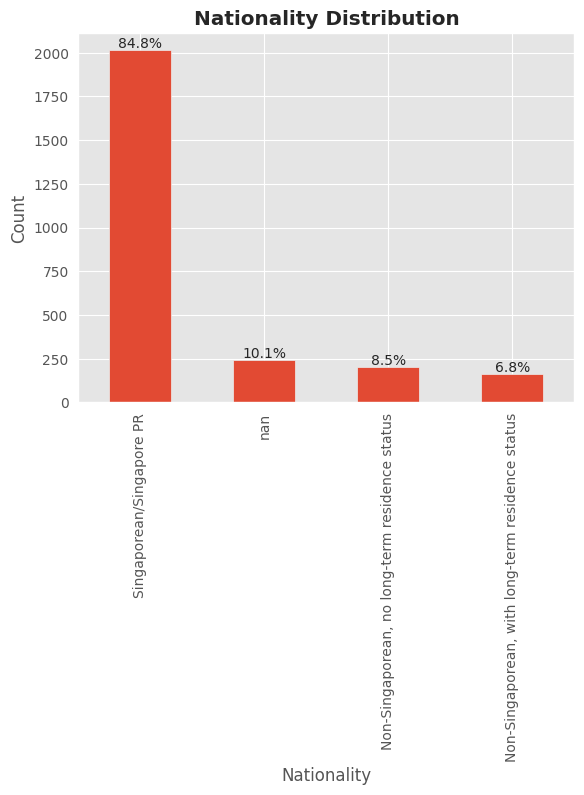

In [ ]:
#Nationality Distribution
ax = df['Nationality'].value_counts(dropna=False).sort_values(ascending=False).plot(kind='bar')

plt.title('Nationality Distribution')
plt.xlabel('Nationality')
plt.ylabel('Count')

# Add percentage labels
total =  df['Nationality'].value_counts().sum()
for p in ax.patches:
    percentage = (p.get_height() / total) * 100
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

Subject Distribution

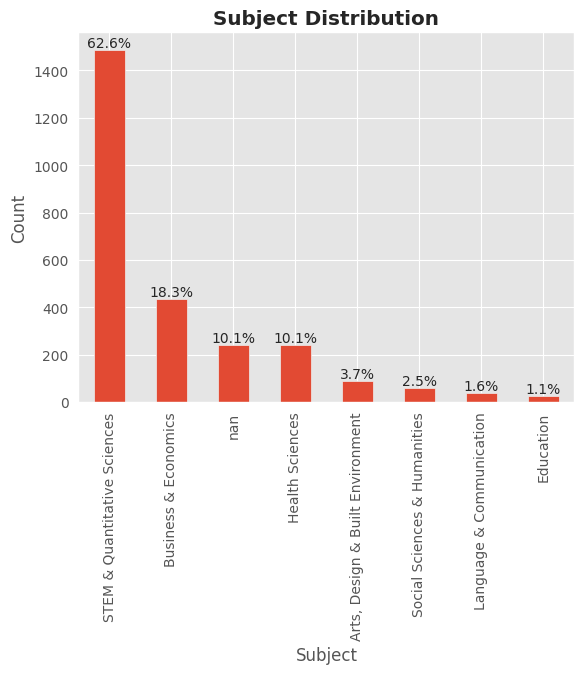

In [ ]:
#Subject Distribution
ax = df['Subject'].value_counts(dropna=False).sort_values(ascending=False).plot(kind='bar')

plt.title('Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Count')

# Add percentage labels
total =  df['Nationality'].value_counts().sum()
for p in ax.patches:
    percentage = (p.get_height() / total) * 100
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

4. Survey Variables

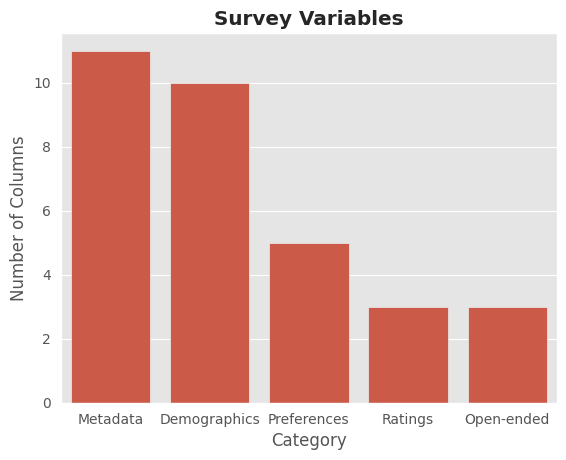

In [ ]:
Metadata = [
    'Response ID', 'Time Started', 'Date Submitted', 'Status',
    'Language', 'SessionID', 'User Agent', 'Tags', 'IP Address',
    'Longitude', 'Latitude'
]

Demographics = [
    'Country', 'City', 'State/Region', 'Postal', 'Institution',
    'Year_of_Study', 'Qualification', 'Subject',
    'Nationality', 'Gender'
]

Preferences = [
    'Types of roles available:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)',
    'Career progression and development:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)',
    'Compensation and benefits:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)',
    'Work-life balance and culture:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)',
    'Application and interview process:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)'
]

Ratings = [
    'Perception',
    'Attractiveness_Rating',
    'Motivation_Factor'
]

Open_ended = [
    'Other - Write In (Required):What do you wish to learn more about regarding the organisation as an employer? (Pick 3)',
    'Other - Write In (Required):What do you wish to learn more about regarding the organisation as an employer? (Pick 3)  .1',
    'Other - Write In (Required):Which of these factors would most motivate you to apply for a position at the organisation?'
]


category_counts = {
    'Metadata': len(Metadata),
    'Demographics': len(Demographics),
    'Preferences': len(Preferences),
    'Ratings': len(Ratings),
    'Open-ended': len(Open_ended)
}

df_counts = pd.DataFrame.from_dict(
    category_counts,
    orient='index',
    columns=['Number of Columns']
)

sns.barplot(data=df_counts, x=df_counts.index, y="Number of Columns")
plt.title('Survey Variables')
plt.xlabel('Category')
plt.ylabel('Number of Columns')
plt.show()

5. Data Quality Notes

In [ ]:
singapore_institutions = [
    'National University of Singapore (NUS)',
    'Nanyang Technological University (NTU)',
    'Singapore Management University (SMU)',
    'Singapore Institute of Technology (SIT)',
    'Singapore University of Technology and Design (SUTD)',
    'Singapore University of Social Sciences (SUSS)',
    'Yale-NUS College',
    'National Institute of Education (NIE)',
    'LASALLE College of the Arts (LASALLE)',
    'Nanyang Academy of Fine Arts (NAFA)',
    'SIM Global Education',
    'Kaplan Singapore',
    'PSB Academy',
    'EASB East Asia Institute of Management',
    'Management Development Institute of Singapore (MDIS)',
    'James Cook University Singapore (JCU)',
    'Curtin University Singapore',
    'Duke-NUS Graduate Medical School',
    'Johns Hopkins Singapore (JHS)',
    'INSEAD Asia',
    'Embry-Riddle Aeronautical University Singapore',
    'S. P. Jain School of Global Management (SPJ)',
    'University of Nevada Las Vegas Singapore (UNLV)',
    'Chatsworth Medi@rt Academy'
]

singapore_students = df[
    (df['Institution'].isin(singapore_institutions)) &
    (df['Institution'].notna())
]

len(singapore_students)
country_breakdown = singapore_students['Country'].value_counts()
non_sg_ip = singapore_students[singapore_students['Country'] != 'Singapore']


# 7.0% geographic anomalies: 165 students from Singapore institutions with non-Singapore IPs
 # (likely VPN usage, study abroad programs, or students currently overseas)
print(f"Singapore students with NON-Singapore IPs:")
print(f"Count: {len(non_sg_ip)}")
print(f"Percentage: {(len(non_sg_ip) / len(singapore_students) * 100):.2f}%")


#1. Status column has ['Complete','Disqualified','Partial']
 #2. To be considered Complete the following 3 questions must be answered

 #- Which of these statements best describes your current perception of the organisation as an employer
 #- On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?
 #- Which of these factors would most motivate you to apply for a position at the organisation?



Singapore students with NON-Singapore IPs:
Count: 165
Percentage: 6.99%


In [ ]:
#for darren
DF = df.copy()

# Extra data cleaning

 Drop Disqualified and Partial

In [ ]:

df[df['Status']=='Disqualified'].isna().sum()

,0
Response ID,0
Time Started,0
Date Submitted,0
Status,0
Language,0
SessionID,0
User Agent,0
Tags,465
IP Address,0
Longitude,3


In [ ]:
df[df['Status']=='Partial'].isna().sum()

,0
Response ID,0
Time Started,0
Date Submitted,0
Status,0
Language,0
SessionID,0
User Agent,0
Tags,301
IP Address,0
Longitude,0


In [ ]:
Df = df
df=df[df['Status']=='Complete']

 Clean Year of Study (str -> int)

In [ ]:
#df['Year_of_Study'] = df['Year_of_Study'].str.extract('(\d+)').astype(int)
df['Year_of_Study'] = df['Year_of_Study'].astype(str).str.extract('(\d+)').fillna(0).astype(int)

 Map Perception (Ordinal Ranking)

In [ ]:
perception_mapping = {
    "I’m not familiar enough with the organisation to form a solid opinion": 0,
    "I recognise the organisation by name, but don’t have a clear impression of them": 1,
    "I have a general positive impression of the organisation, but don’t know much about what jobs they offer": 2,
    "I’m familiar with the organisation and would consider them as a potential employer": 3
}
df["Perception"] = df["Perception"].map(perception_mapping)


 OHE Motivation

In [ ]:
df['Motivation_Factor'].value_counts()

,count
Motivation_Factor,
Meaningful work impact,643
Career growth opportunities,400
Work-life balance,354
Job security,253
Learning and development,102
Compensation package,89
Other - Write In (Required),7


In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
motivation_encoded = ohe.fit_transform(df[['Motivation_Factor']])

motivation_df = pd.DataFrame(motivation_encoded, columns=ohe.get_feature_names_out(['Motivation_Factor']))
motivation_df.index = df.index
df = pd.concat([df, motivation_df], axis=1)
df.drop('Motivation_Factor', axis=1, inplace=True)

 Convert Pick 3s

In [ ]:
pick3_cols = df.columns.tolist()[22:28]

new_cols = [
    col.replace(':', '_')
       .replace('?', '')
       .replace('(Pick 3)', '')
       .strip() + '_Binary'
    for col in pick3_cols
]

for old, new in zip(pick3_cols, new_cols):
    df[new] = df[old].notna().astype(int)
cols = df.columns.tolist()

for old, new in zip(pick3_cols, new_cols):
    cols[cols.index(old)] = new

df = df[cols[:-6]]


In [ ]:
df.rename(
    columns={
        'Other - Write In (Required)_What do you wish to learn more about regarding the organisation as an employer_Binary': "Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary",
        'Other - Write In (Required):What do you wish to learn more about regarding the organisation as an employer? (Pick 3) \xa0.1': 'Other - Write In (Required):What do you wish to learn more about regarding the organisation as an employer?',
    }, inplace=True
)

# Identify patterns, correlations, or redundancies in survey questions that suggest opportunities for improvement

In [ ]:
df.columns

Index(['Response ID', 'Time Started', 'Date Submitted', 'Status', 'Language',
       'SessionID', 'User Agent', 'Tags', 'IP Address', 'Longitude',
       'Latitude', 'Country', 'City', 'State/Region', 'Postal', 'Institution',
       'Year_of_Study', 'Qualification', 'Subject', 'Nationality', 'Gender',
       'Perception',
       'Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Other - Write In (Required): What do y

In [ ]:
df_q1 = df.copy()

In [ ]:
df_q1.Qualification.value_counts()

,count
Qualification,
Bachelor's Degree,1848


In [ ]:
df_model = df_q1.copy()

categorical_features = []#['Institution', 'Subject', 'Gender', 'Nationality']

numerical_features = ['Year_of_Study', 'Perception']

motivation_and_pick3_cols = [col for col in df_model.columns if col.startswith('Motivation_Factor_') or col.endswith('_Binary')]

In [ ]:
target_variable = 'Attractiveness_Rating'

all_features = categorical_features + numerical_features + motivation_and_pick3_cols + [target_variable]
df_model = df_model[all_features]

In [ ]:
df.shape

(1848, 38)

In [ ]:
o_df.columns

Index(['Response ID', 'Time Started', 'Date Submitted', 'Status', 'Language',
       'SessionID', 'User Agent', 'Tags', 'IP Address', 'Longitude',
       'Latitude', 'Country', 'City', 'State/Region', 'Postal',
       'Which higher education institution do you or did you study at?',
       'What is your current year of study as of 2025?',
       'What will be your highest qualification when you graduate?',
       'Which of the following best describes the main subject that you are studying? ',
       'Please indicate your nationality.', 'What is your gender?',
       'Which of these statements best describes your current perception of the organisation as an employer?',
       'Types of roles available:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)  ',
       'Career progression and development:What do you wish to learn more about regarding the organisation as an employer? (Pick 3)  ',
       'Compensation and benefits:What do you wish to learn 

In [ ]:
df_model.columns

Index(['Year_of_Study', 'Perception',
       'Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Motivation_Factor_Career growth opportunities',
       'Motivation_Factor_Compensation package',
       'Motivation_Factor_Job security',
       'Motivation_Factor_Learning and development',
       '

In [ ]:
df_model

,Year_of_Study,Perception,Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary,Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary,Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary,Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary,Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary,Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary,Motivation_Factor_Career growth opportunities,Motivation_Factor_Compensation package,Motivation_Factor_Job security,Motivation_Factor_Learning and development,Motivation_Factor_Meaningful work impact,Motivation_Factor_Other - Write In (Required),Motivation_Factor_Work-life balance,Attractiveness_Rating
3,4,3,1,1,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
9,3,1,0,1,1,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0
13,3,2,0,1,1,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
16,2,2,0,1,1,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
17,2,1,1,1,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606,4,1,1,0,1,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
2608,3,1,1,1,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
2609,3,2,1,0,1,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
2610,2,1,0,1,1,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0


In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_features = ohe.fit_transform(df_model[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_features), index=df_model.index)
df_model = pd.concat([df_model[numerical_features + motivation_and_pick3_cols + [target_variable]], encoded_df], axis=1)
df_model.dropna(inplace=True)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import re

X = df_model.drop(columns=[target_variable])
y = df_model[target_variable]

X.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 5.2662


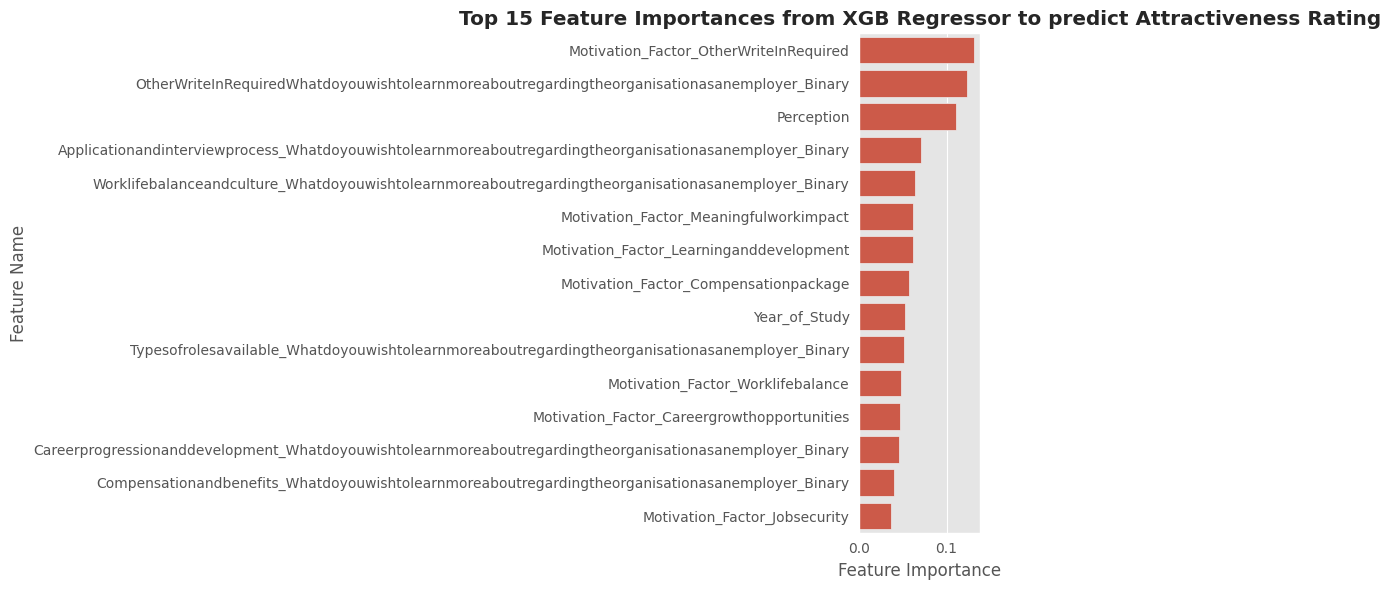

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

N = 15
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(N))
plt.title(f'Top {N} Feature Importances from XGB Regressor to predict Attractiveness Rating')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [ ]:
feature_importances

,feature,importance
13,Motivation_Factor_OtherWriteInRequired,0.131717
7,OtherWriteInRequiredWhatdoyouwishtolearnmoreab...,0.123435
1,Perception,0.111326
6,Applicationandinterviewprocess_Whatdoyouwishto...,0.070130
5,Worklifebalanceandculture_Whatdoyouwishtolearn...,0.063320
12,Motivation_Factor_Meaningfulworkimpact,0.061794
11,Motivation_Factor_Learninganddevelopment,0.061671
9,Motivation_Factor_Compensationpackage,0.057001
0,Year_of_Study,0.052814
2,Typesofrolesavailable_Whatdoyouwishtolearnmore...,0.051034


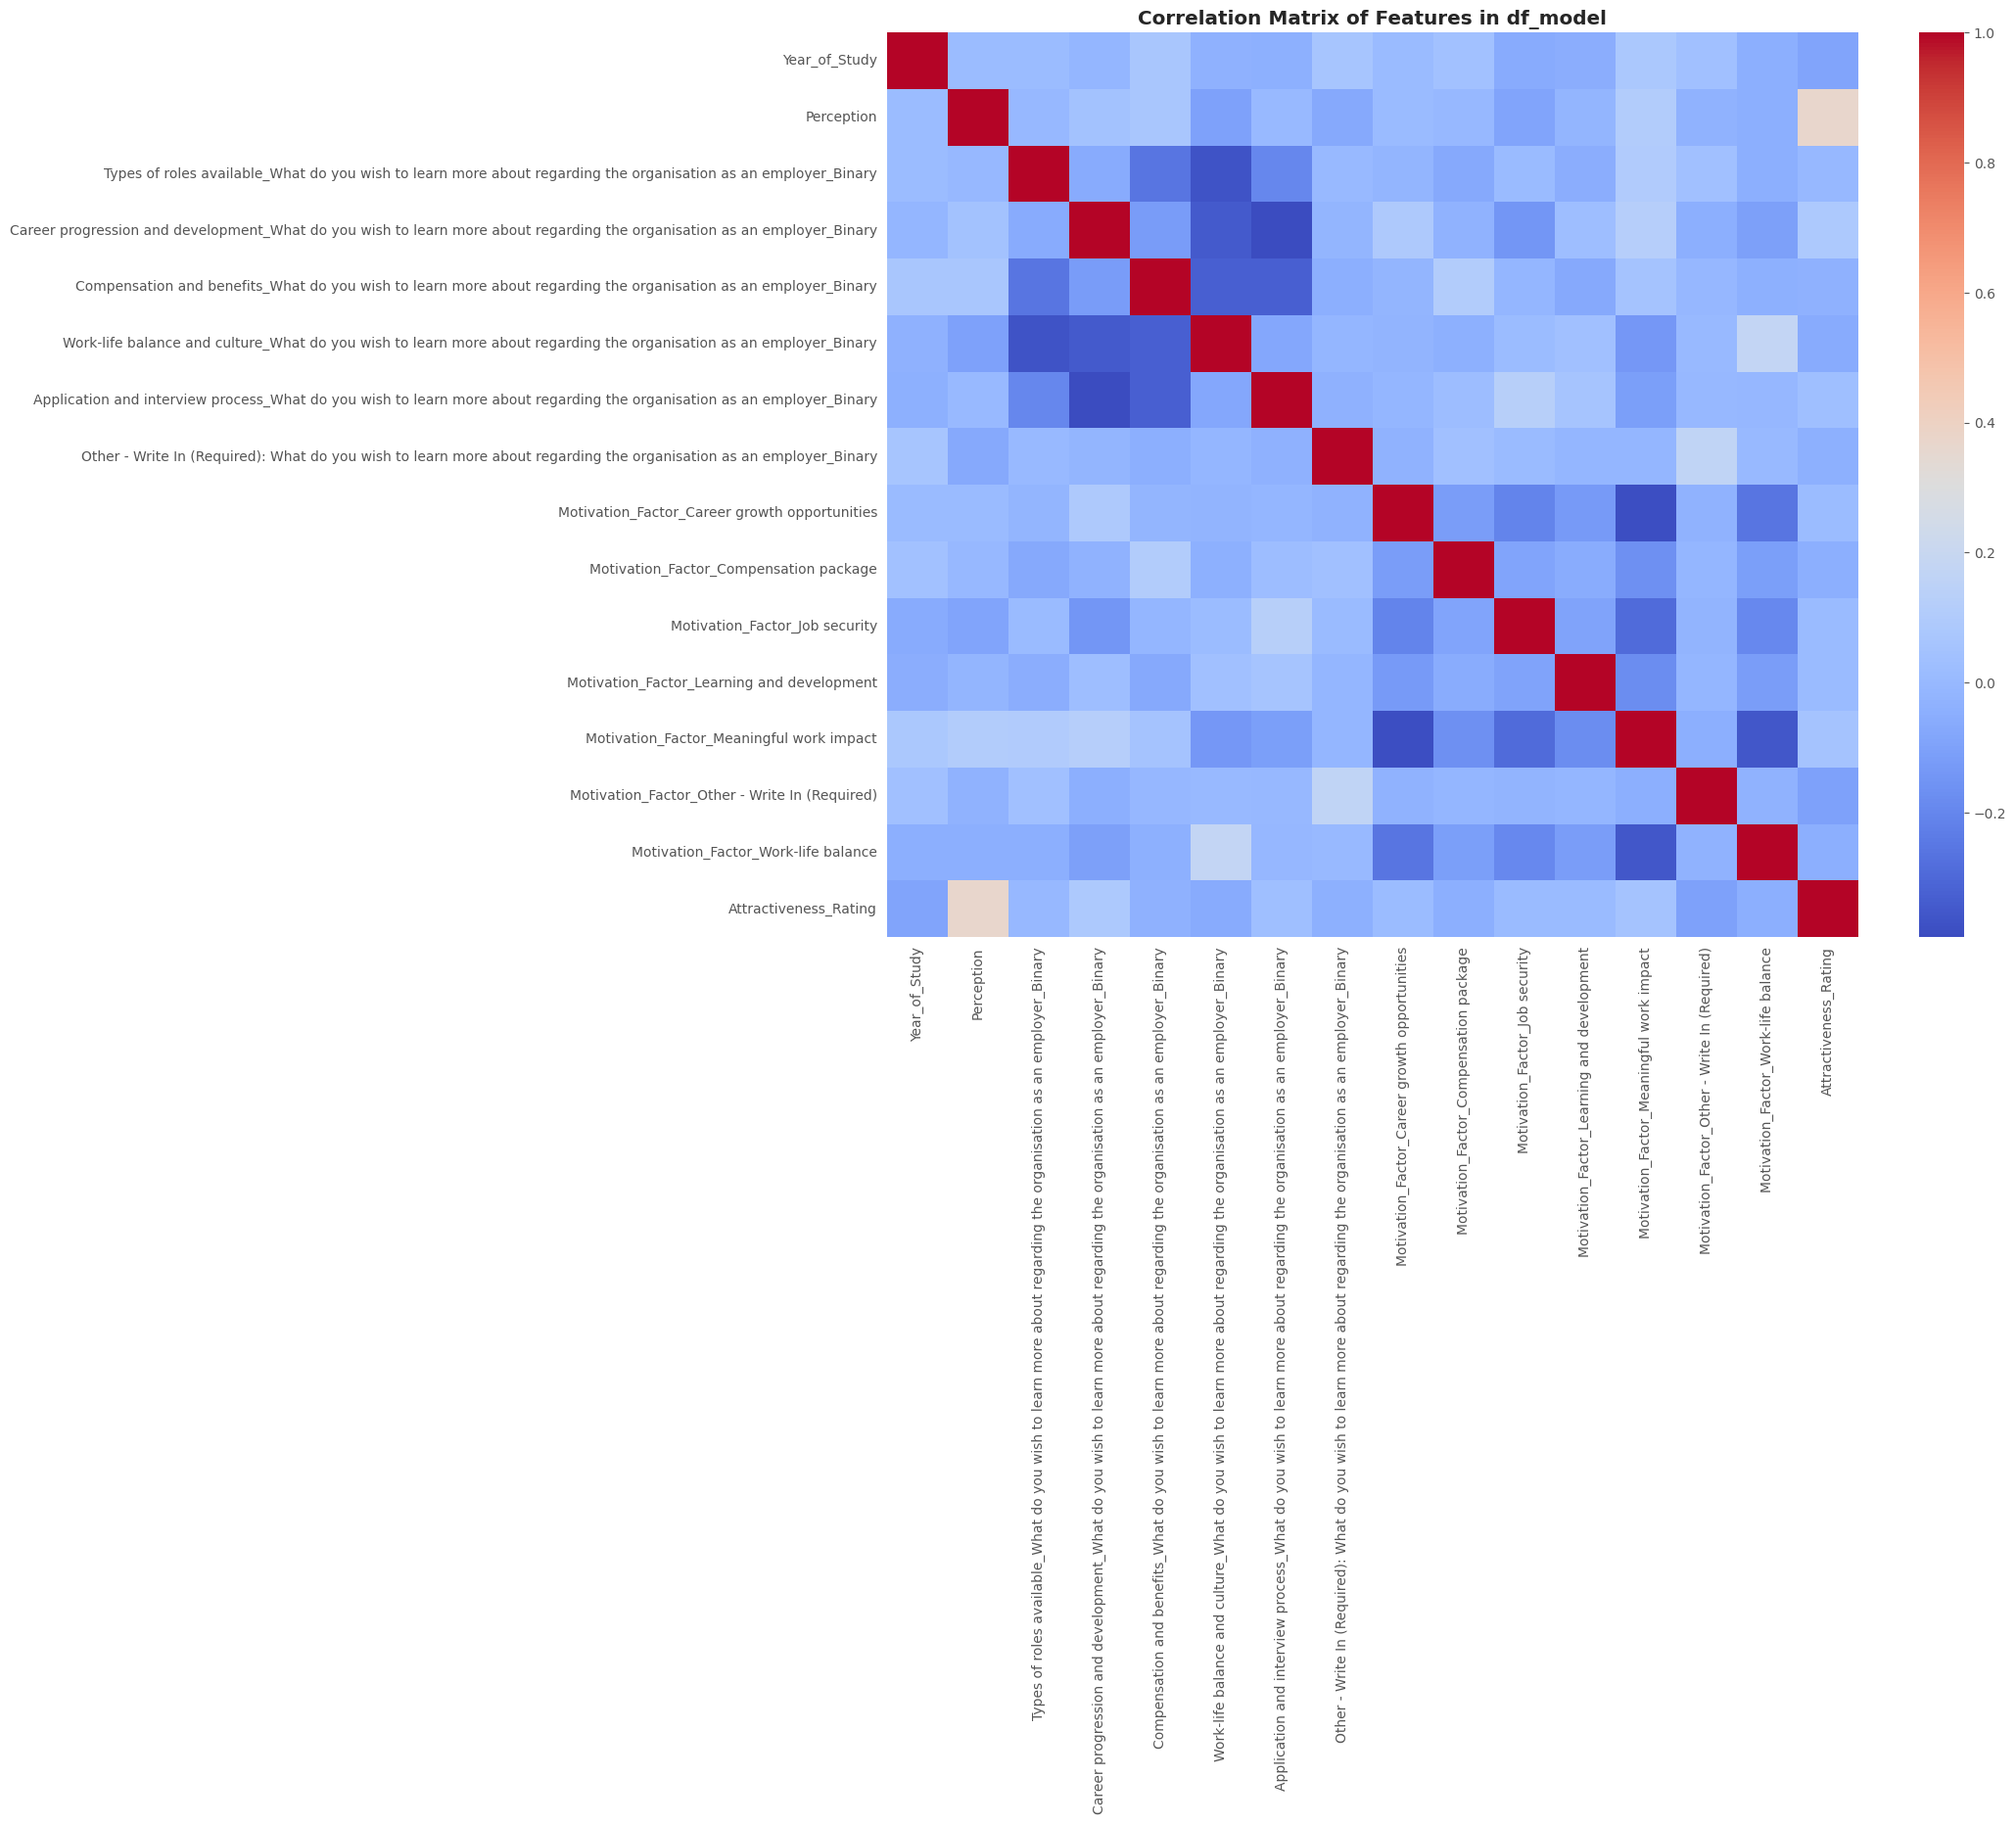

In [ ]:
correlation_matrix = df_model.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features in df_model')
plt.show()

# Understand factors for partial or incomplete responses

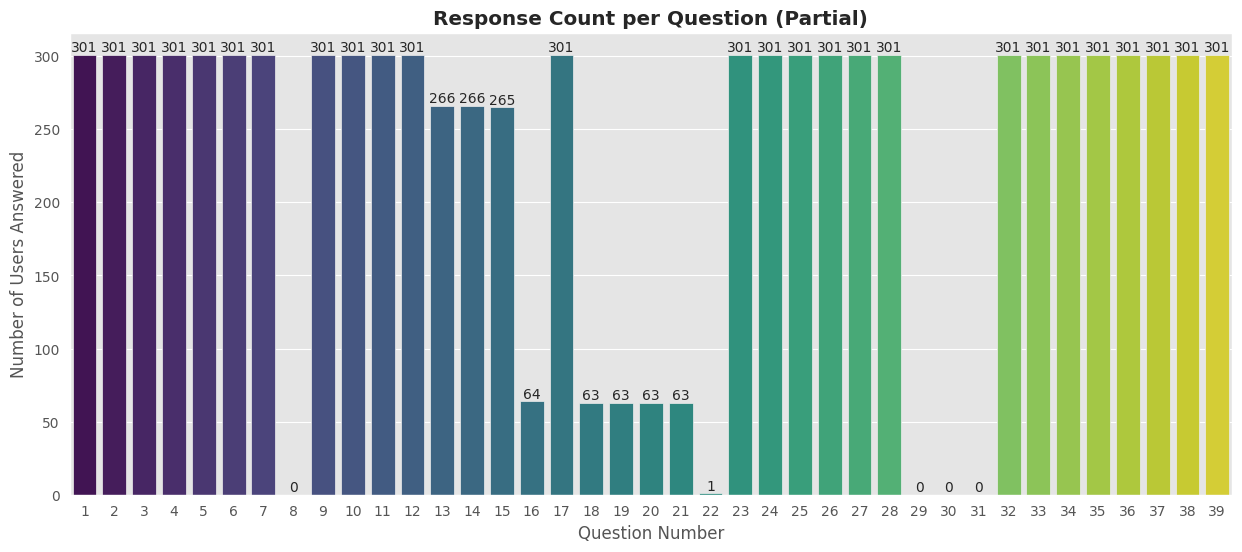

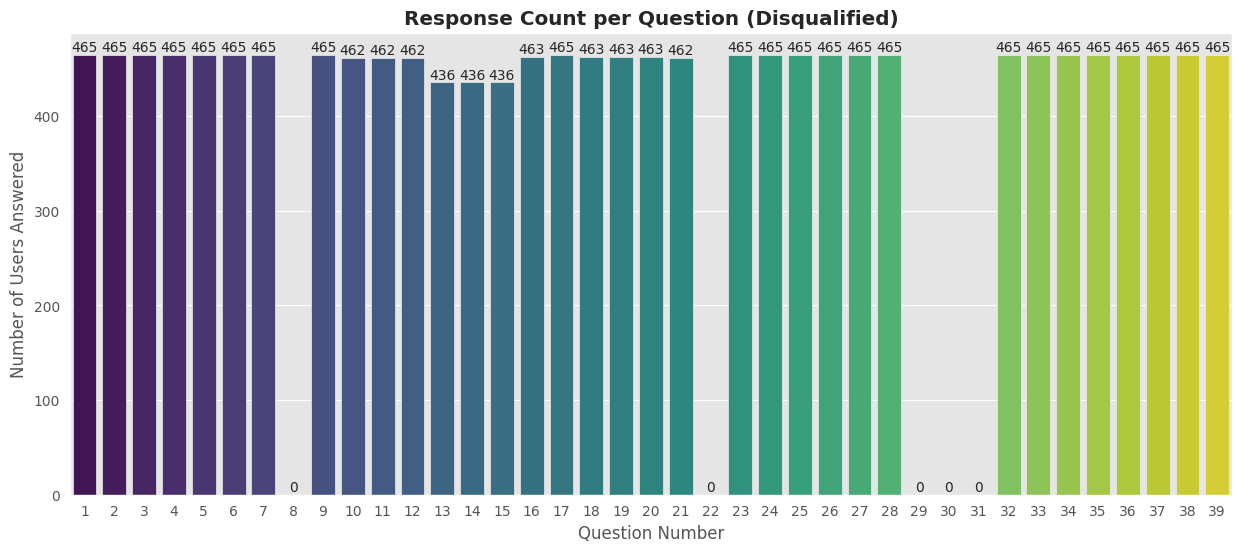

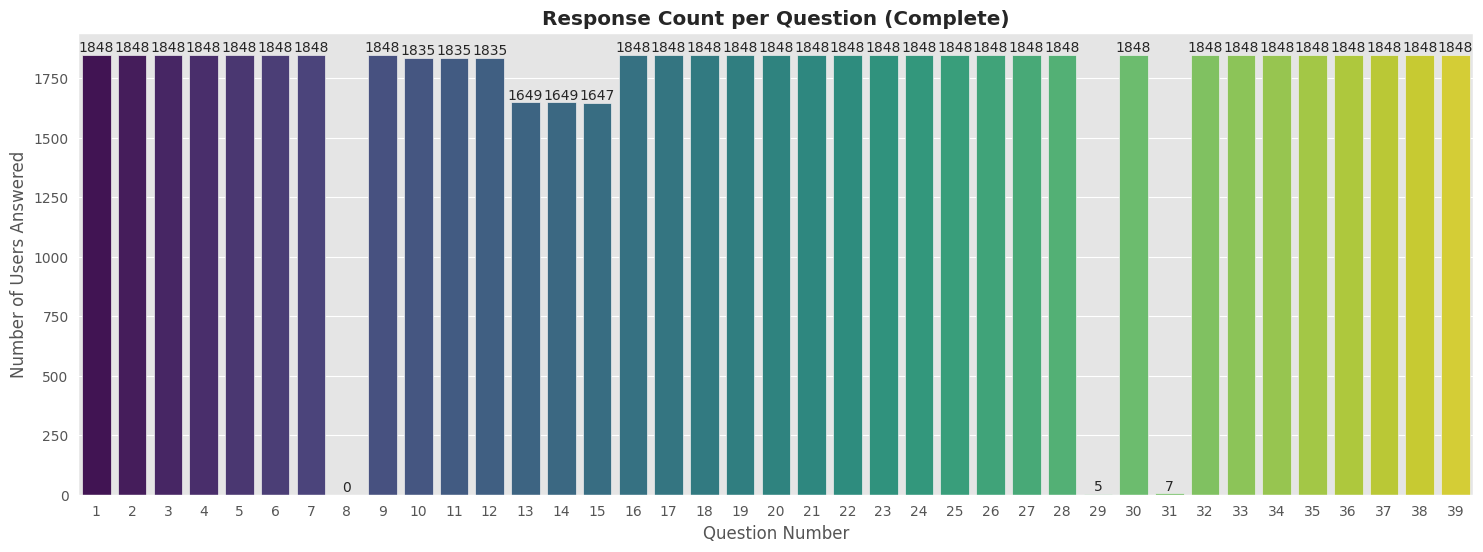

[1: Response ID]
[2: Time Started]
[3: Date Submitted]
[4: Status]
[5: Language]
[6: SessionID]
[7: User Agent]
[8: Tags]
[9: IP Address]
[10: Longitude]
[11: Latitude]
[12: Country]
[13: City]
[14: State/Region]
[15: Postal]
[16: Institution]
[17: Year_of_Study]
[18: Qualification]
[19: Subject]
[20: Nationality]
[21: Gender]
[22: Perception]
[23: Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary]
[24: Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary]
[25: Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary]
[26: Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary]
[27: Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary]
[28: Other - Write In (Required): What do yo

In [ ]:
# cleaning the full complete dataset first
r_df = Df.copy()
r_df['Year_of_Study'] = r_df['Year_of_Study'].astype(str).str.extract('(\d+)').fillna(0).astype(int)
perception_mapping = {
    "I’m not familiar enough with the organisation to form a solid opinion": 0,
    "I recognise the organisation by name, but don’t have a clear impression of them": 1,
    "I have a general positive impression of the organisation, but don’t know much about what jobs they offer": 2,
    "I’m familiar with the organisation and would consider them as a potential employer": 3
}
r_df["Perception"] = r_df["Perception"].map(perception_mapping)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
motivation_encoded = ohe.fit_transform(r_df[['Motivation_Factor']])

motivation_df = pd.DataFrame(motivation_encoded, columns=ohe.get_feature_names_out(['Motivation_Factor']))
motivation_df.index = r_df.index
r_df = pd.concat([r_df, motivation_df], axis=1)
r_df.drop('Motivation_Factor', axis=1, inplace=True)

pick3_cols = r_df.columns.tolist()[22:28]

new_cols = [
    col.replace(':', '_')
       .replace('?', '')
       .replace('(Pick 3)', '')
       .strip() + '_Binary'
    for col in pick3_cols
]

for old, new in zip(pick3_cols, new_cols):
    r_df[new] = r_df[old].notna().astype(int)
cols = r_df.columns.tolist()

for old, new in zip(pick3_cols, new_cols):
    cols[cols.index(old)] = new

r_df = r_df[cols[:-6]]
r_df.rename(
    columns={
        'Other - Write In (Required)_What do you wish to learn more about regarding the organisation as an employer_Binary': "Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary",
        'Other - Write In (Required):What do you wish to learn more about regarding the organisation as an employer? (Pick 3) \xa0.1': 'Other - Write In (Required):What do you wish to learn more about regarding the organisation as an employer?',
    }, inplace=True
)

# Splitting into partial, disqualified, complete datasets

ry_df = r_df.copy()

p_df = ry_df[ry_df['Status'] == 'Partial']
d_df = ry_df[ry_df['Status'] == 'Disqualified']
c_df = ry_df[ry_df['Status'] == 'Complete']

# Plotting bar graph of how many respondents per question

question_cols = p_df.columns[0:]
counts_per_question = p_df[question_cols].notnull().sum()
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=np.arange(1, len(counts_per_question) + 1),
                 y=counts_per_question.values,
                 palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Response Count per Question (Partial)')
plt.xlabel('Question Number')
plt.ylabel('Number of Users Answered')
plt.show()

question_cols = d_df.columns[0:]
counts_per_question = d_df[question_cols].notnull().sum()
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=np.arange(1, len(counts_per_question) + 1),
                 y=counts_per_question.values,
                 palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Response Count per Question (Disqualified)')
plt.xlabel('Question Number')
plt.ylabel('Number of Users Answered')
plt.show()

question_cols = c_df.columns[0:]
counts_per_question = c_df[question_cols].notnull().sum()
plt.figure(figsize=(18, 6))
ax = sns.barplot(x=np.arange(1, len(counts_per_question) + 1),
                 y=counts_per_question.values,
                 palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Response Count per Question (Complete)')
plt.xlabel('Question Number')
plt.ylabel('Number of Users Answered')
plt.show()

question_cols = d_df.columns[0:]
for i, question in enumerate(question_cols, 1):
    print(f"[{i}: {question}]")


In [ ]:
# Analyse p_df, d_df, c_df to see the differences

print(p_df.columns)

# Comparing Time Taken to complete the survey

pdur = ((p_df['Date Submitted'] - p_df['Time Started']).dt.total_seconds()/60).tolist()
ddur = ((d_df['Date Submitted'] - d_df['Time Started']).dt.total_seconds()/60).tolist()
cdur = ((c_df['Date Submitted'] - c_df['Time Started']).dt.total_seconds()/60).tolist()

# helper function using z-score normalization
def zscore(data):
    mean = np.mean(data)
    std = np.std(data)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    outliers = [x for x in data if x > upper]
    clean_data = [x for x in data if x <= upper]
    return np.mean(clean_data)

print(zscore(pdur), zscore(ddur), zscore(cdur))


# Comparing User Agent

pcounts = p_df['User Agent'].str.strip().value_counts()
dcounts = d_df['User Agent'].str.strip().value_counts()
ccounts = c_df['User Agent'].str.strip().value_counts()
print(pcounts, dcounts, ccounts)

# Comparing Qualification

print(p_df['Qualification'].value_counts())
print(d_df['Qualification'].value_counts())
print(c_df['Qualification'].value_counts())

Index(['Response ID', 'Time Started', 'Date Submitted', 'Status', 'Language',
       'SessionID', 'User Agent', 'Tags', 'IP Address', 'Longitude',
       'Latitude', 'Country', 'City', 'State/Region', 'Postal', 'Institution',
       'Year_of_Study', 'Qualification', 'Subject', 'Nationality', 'Gender',
       'Perception',
       'Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary',
       'Other - Write In (Required): What do y

# demographic and behavioral segements


Among respondants who fully completed the surveys: We split the respondants into 3 distinct clusters.


Cluster 0
- Profile: Y2-Y4 Students, with a majority from NUS with STEM and Quantitative Sciences
- Behaviour Characteristics: Most career orientated Meaningful work impact(37.3%), Moderate work balance (18.4%), slightly lower than year 1 students (cluster 2), Past the exploratory stage with Learning and development at (4.4%), Lower compensation focus than compared to year 1 students with Compensation package at (5.0%)
- Psychographics Profile: Missen-driven professionals aimed in making impact rather than maximise financial returns


Cluster 1
- Profile 1: Y1-Y4 Students with high cocentration of Y2 students. Dominated by NTU students with notable institutional diversity. Only cluster where Business and Economics students are the majority
- Behaviour Characteristics: Pragmatic career orientation with highest job security focus among the clusters. Equal emphasis on "Learning and development" and "Compensation"
- Psychographics Profile: Business minded pragmatists seeking stable career paths

Cluster 2
- Profile: Y1 students, primary NUS students. STEM and Quantitative Sciences focused but more diverse compared to Cluser 0
- Behaviour Characteristics: Still in exploratory mode, highest worklife balance and less financially driven among all clusters
- Psychographics Profile: Idealistic newcomers prioritizing balance and growth, more of wellness-conscious generation entering university


# Key Behavioral Insights and Demographic patterns Across Segments

1. Year of Study drives Behavioral Differences
- work life balance: Work-life balance: Freshmen prioritize it MORE (20.7%) vs seniors (18.4-18.6%)
  - insight: Younger Students are more wellness conscious.
- Learning and development: Freshmen value it MORE (6.9%) vs seniors (4.4-5.8%)
  - insight: Curiosity decreases as students progress, they become more goal-directed.
- Compensation: Freshmen care LESS about salary (3.5%) vs seniors (5.0-5.8%)
  - insight: Students worry about their expenses and cost of living as they go up the years.
2. Meaningful Work Impact
- ALL three segments prioritize meaningful work (33-37%) as #1 motivation
  - insight: Contributing to society and doing something meaningful resonates with the student generation.
3. Institutional Diversity Patterns
- In terms of Institutions, Cluster 0 is most homogeneous with Cluster 1 being most diverse in terms of Institutions. Cluster 0 is STEM dominated while CLuster 1 is Business & Economics dominated.
  - insight: Business education draws from broader institutional base while STEM concentrates at elite universities.

#  Strategic Recommendations

1. Recruiting/Company Branding
- Lead with "meaningful impact" - it resonates with ALL segments
- Cluster specfic tweaks
  - Cluster 0: Emphasize technical innovation and societal impact
  - Cluster 1: Highlight career progression and stability
  - Cluster 2: Showcase learning culture and work-life policies
2. Policy/Student Services

- Mental health support: Freshmen prioritize mental health the most - target wellness programs here
- Career services: Differentiate by year (Year 1 needs exploration, upper years need placement/opportunities)
- Financial literacy: Upper years care more about compensation (introduce financial planning in Year 2+)

In [ ]:
df = DF

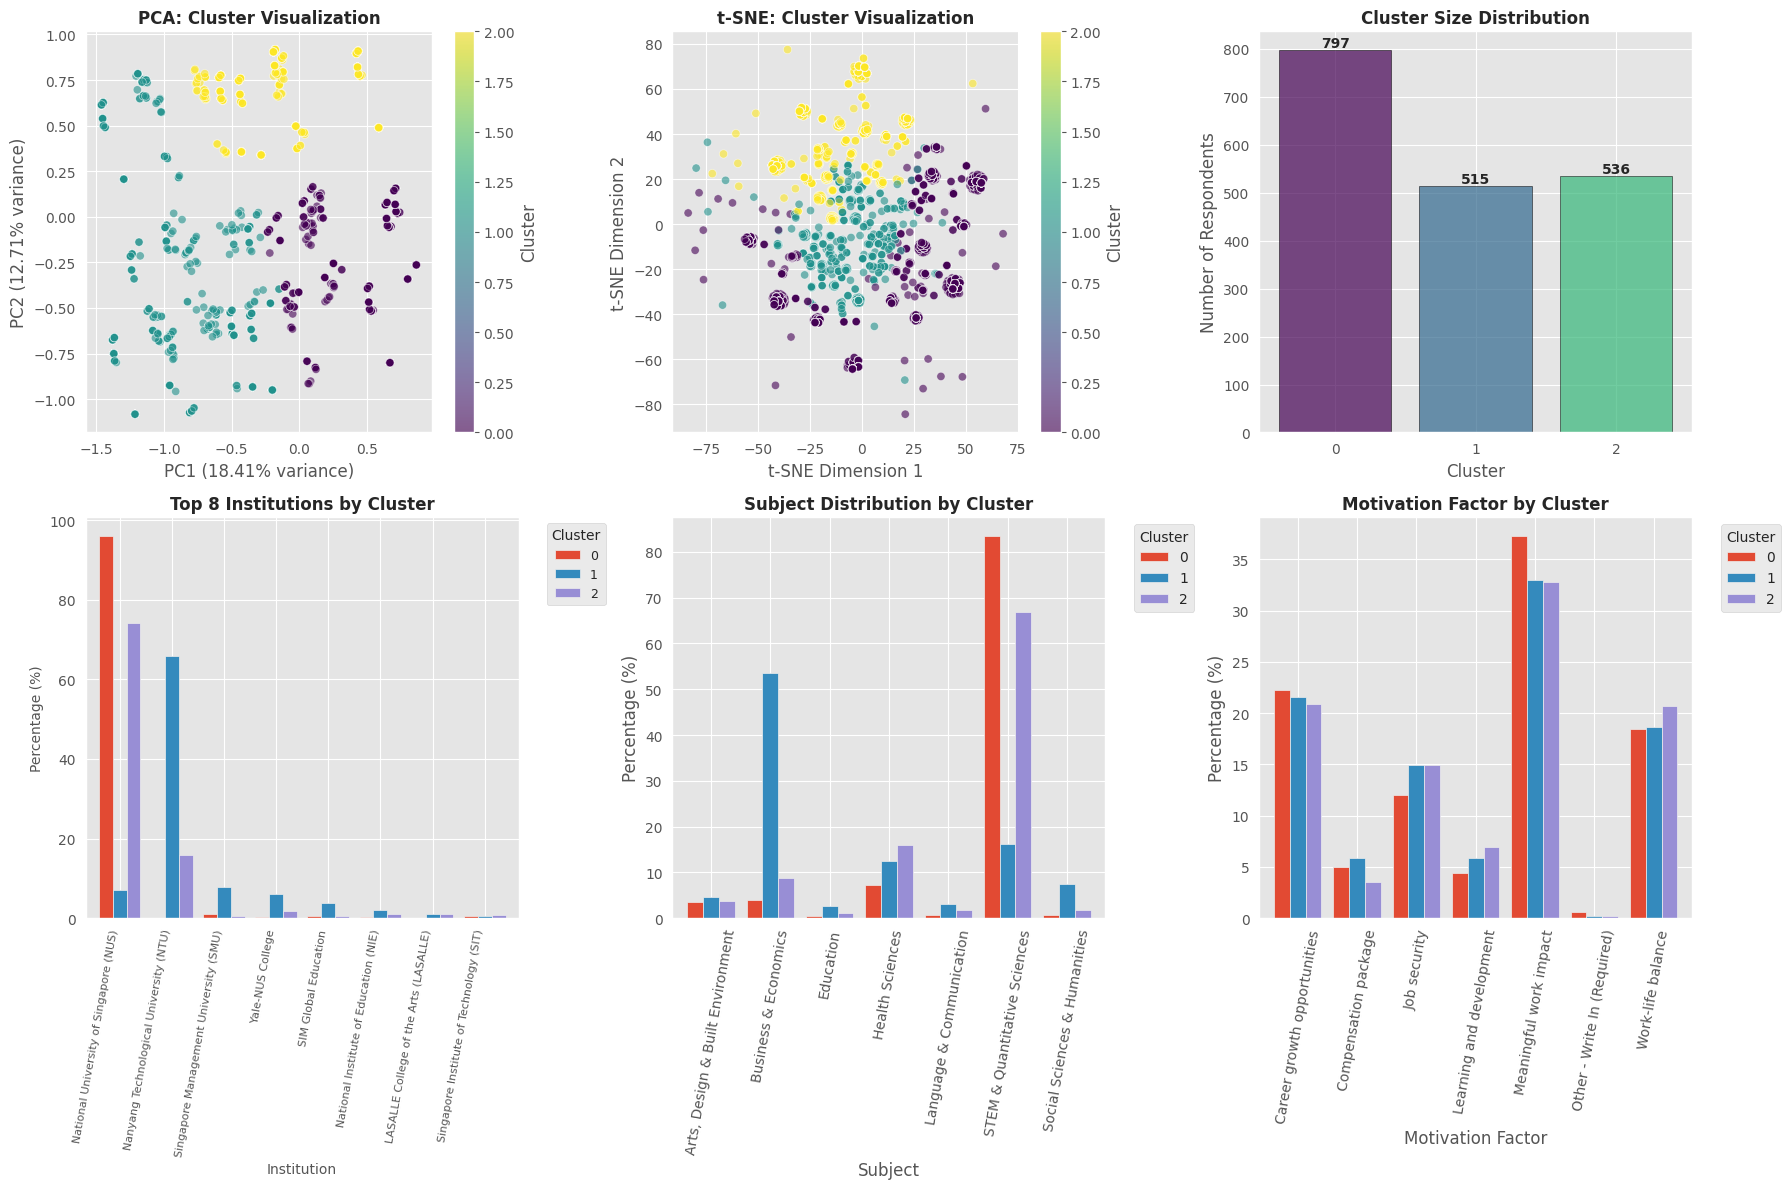

In [ ]:
work = df[df['Status']=='Complete']
work = work[['Institution','Subject','Year_of_Study','Motivation_Factor', 'Attractiveness_Rating']]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
work_encoded = ohe.fit_transform(work[['Institution','Subject','Year_of_Study','Motivation_Factor']])


km = KMeans(n_clusters=3, random_state=42, n_init=10)
work['Cluster'] = km.fit_predict(work_encoded)


pca = PCA(n_components=2, random_state=42)
work_pca = pca.fit_transform(work_encoded)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
work_tsne = tsne.fit_transform(work_encoded)


fig = plt.figure(figsize=(18, 12))

# Plot 1: PCA Visualization
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(work_pca[:, 0], work_pca[:, 1],
                      c=work['Cluster'], cmap='viridis',
                      alpha=0.6, edgecolors='w', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA: Cluster Visualization', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Cluster')

# Plot 2: t-SNE Visualization
ax2 = plt.subplot(2, 3, 2)
scatter2 = ax2.scatter(work_tsne[:, 0], work_tsne[:, 1],
                       c=work['Cluster'], cmap='viridis',
                       alpha=0.6, edgecolors='w', linewidth=0.5)
ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.set_title('t-SNE: Cluster Visualization', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# Plot 3: Cluster Size Distribution
ax3 = plt.subplot(2, 3, 3)
cluster_counts = work['Cluster'].value_counts().sort_index()
bars = ax3.bar(cluster_counts.index, cluster_counts.values,
               color=['#440154', '#31688e', '#35b779'], alpha=0.7, edgecolor='black')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Number of Respondents')
ax3.set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
ax3.set_xticks(cluster_counts.index)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

# Plot 4: Institution Distribution by Cluster (Top institutions only)
ax4 = plt.subplot(2, 3, 4)
inst_cluster = pd.crosstab(work['Cluster'], work['Institution'], normalize='index') * 100

# Get top 8 institutions by total count across all clusters
top_institutions = work['Institution'].value_counts().head(8).index
inst_cluster_filtered = inst_cluster[top_institutions]

inst_cluster_filtered.T.plot(kind='bar', ax=ax4, stacked=False, width=0.8)
ax4.set_xlabel('Institution', fontsize=10)
ax4.set_ylabel('Percentage (%)', fontsize=10)
ax4.set_title('Top 8 Institutions by Cluster', fontsize=12, fontweight='bold')
ax4.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax4.tick_params(axis='x', rotation=80, labelsize=8)
plt.setp(ax4.xaxis.get_majorticklabels(), ha='right')

# Plot 5: Subject Distribution by Cluster
ax5 = plt.subplot(2, 3, 5)
subj_cluster = pd.crosstab(work['Cluster'], work['Subject'], normalize='index') * 100
subj_cluster.T.plot(kind='bar', ax=ax5, stacked=False, width=0.8)
ax5.set_xlabel('Subject')
ax5.set_ylabel('Percentage (%)')
ax5.set_title('Subject Distribution by Cluster', fontsize=12, fontweight='bold')
ax5.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.tick_params(axis='x', rotation=80)

# Plot 6: Motivation Factor Distribution by Cluster
ax6 = plt.subplot(2, 3, 6)
motiv_cluster = pd.crosstab(work['Cluster'], work['Motivation_Factor'], normalize='index') * 100
motiv_cluster.T.plot(kind='bar', ax=ax6, stacked=False, width=0.8)
ax6.set_xlabel('Motivation Factor')
ax6.set_ylabel('Percentage (%)')
ax6.set_title('Motivation Factor by Cluster', fontsize=12, fontweight='bold')
ax6.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax6.tick_params(axis='x', rotation=80)

plt.tight_layout()
plt.show()

In [ ]:
print("="*80)
print("CLUSTER SEGMENT PROFILING")
print("="*80)

for cluster_id in sorted(work['Cluster'].unique()):
    cluster_data = work[work['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(work)) * 100

    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - {cluster_size} respondents ({cluster_pct:.1f}% of total)")
    print(f"{'='*80}")

    # Institution profile
    print(f"\n INSTITUTION PROFILE:")
    inst_dist = cluster_data['Institution'].value_counts()
    for inst, count in inst_dist.items():
        pct = (count / cluster_size) * 100
        print(f"   • {inst}: {count} ({pct:.1f}%)")

    # Subject profile
    print(f"\n SUBJECT PROFILE:")
    subj_dist = cluster_data['Subject'].value_counts()
    for subj, count in subj_dist.items():
        pct = (count / cluster_size) * 100
        print(f"   • {subj}: {count} ({pct:.1f}%)")

    # Year of Study profile
    print(f"\n YEAR OF STUDY PROFILE:")
    year_dist = cluster_data['Year_of_Study'].value_counts().sort_index()
    for year, count in year_dist.items():
        pct = (count / cluster_size) * 100
        print(f"   • Year {year}: {count} ({pct:.1f}%)")

    # Motivation Factor profile
    print(f"\n MOTIVATION FACTOR PROFILE:")
    motiv_dist = cluster_data['Motivation_Factor'].value_counts()
    for motiv, count in motiv_dist.items():
        pct = (count / cluster_size) * 100
        print(f"   • {motiv}: {count} ({pct:.1f}%)")



# =============================================================================
# 4. CLUSTER CHARACTERIZATION SUMMARY
# =============================================================================

print("\n" + "="*80)
print("CLUSTER CHARACTERIZATION SUMMARY")
print("="*80)

for cluster_id in sorted(work['Cluster'].unique()):
    cluster_data = work[work['Cluster'] == cluster_id]

    # Find dominant characteristics
    dominant_inst = cluster_data['Institution'].mode()[0]
    dominant_subj = cluster_data['Subject'].mode()[0]
    dominant_year = cluster_data['Year_of_Study'].mode()[0]
    dominant_motiv = cluster_data['Motivation_Factor'].mode()[0]

    print(f"\nCluster {cluster_id} - Dominant Profile:")
    print(f"   → Institution: {dominant_inst}")
    print(f"   → Subject: {dominant_subj}")
    print(f"   → Year: {dominant_year}")
    print(f"   → Motivation: {dominant_motiv}")


print("\n" + "="*80)

CLUSTER SEGMENT PROFILING

CLUSTER 0 - 797 respondents (43.1% of total)

 INSTITUTION PROFILE:
   • National University of Singapore (NUS): 765 (96.0%)
   • Singapore Management University (SMU): 8 (1.0%)
   • SIM Global Education: 5 (0.6%)
   • Singapore Institute of Technology (SIT): 4 (0.5%)
   • James Cook University Singapore (JCU): 3 (0.4%)
   • Yale-NUS College: 3 (0.4%)
   • National Institute of Education (NIE): 2 (0.3%)
   • Curtin University Singapore: 1 (0.1%)
   • Others: 1 (0.1%)
   • INSEAD Asia: 1 (0.1%)
   • PSB Academy: 1 (0.1%)
   • Singapore University of Technology and Design (SUTD): 1 (0.1%)
   • Management Development Institute of Singapore (MDIS): 1 (0.1%)
   • LASALLE College of the Arts (LASALLE): 1 (0.1%)

 SUBJECT PROFILE:
   • STEM & Quantitative Sciences: 665 (83.4%)
   • Health Sciences: 58 (7.3%)
   • Business & Economics: 31 (3.9%)
   • Arts, Design & Built Environment: 28 (3.5%)
   • Language & Communication: 6 (0.8%)
   • Social Sciences & Humanities:

# Insights from the applicant’s perspective on what drives employer attractiveness

In [ ]:
cluster_attr_stats = work.groupby('Cluster')['Attractiveness_Rating'].agg(['mean', 'std', 'count']).round(2)
print("\n" + "="*80)
print("AVERAGE ATTRACTIVENESS SCORE BY CLUSTER")
print("="*80)
print(cluster_attr_stats)


AVERAGE ATTRACTIVENESS SCORE BY CLUSTER
         mean   std  count
Cluster                   
0        6.10  1.96    797
1        6.62  2.29    515
2        6.22  1.97    536


In [ ]:
top_motivators = work['Motivation_Factor'].value_counts().head(5).index
motivator_impact = work[work['Motivation_Factor'].isin(top_motivators)].groupby('Motivation_Factor')['Attractiveness_Rating'].mean().sort_values(ascending=False)

In [ ]:
#i merge work (df with cluster columns) with ry_df(the necessary columns for the code below to work)
j_df=pd.merge(ry_df, work, left_index=True, right_index=True, how='inner')


In [ ]:

pick3_binary_cols = [
    'Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary',
    'Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary',
    'Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary',
    'Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary',
    'Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary',
    'Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary'
]



info_cols_mapping = {
     'Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Roles',
     'Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary':'Info_Career',
    'Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Comp',
    'Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary' :'Info_Culture',
   'Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Process',
     'Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Other'
}

# Create a new DataFrame with just the cluster and mapped binary columns for calculation
work_info_needs = j_df[['Cluster'] + pick3_binary_cols].copy()

work_info_needs.rename(columns={
     'Types of roles available_What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Roles',
     'Career progression and development_What do you wish to learn more about regarding the organisation as an employer_Binary':'Info_Career',
    'Compensation and benefits_What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Comp',
    'Work-life balance and culture_What do you wish to learn more about regarding the organisation as an employer_Binary' :'Info_Culture',
   'Application and interview process_What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Process',
     'Other - Write In (Required): What do you wish to learn more about regarding the organisation as an employer_Binary': 'Info_Other'
},inplace=True)


cluster_info_needs = work_info_needs.groupby('Cluster')[list(info_cols_mapping.values())].mean() * 100

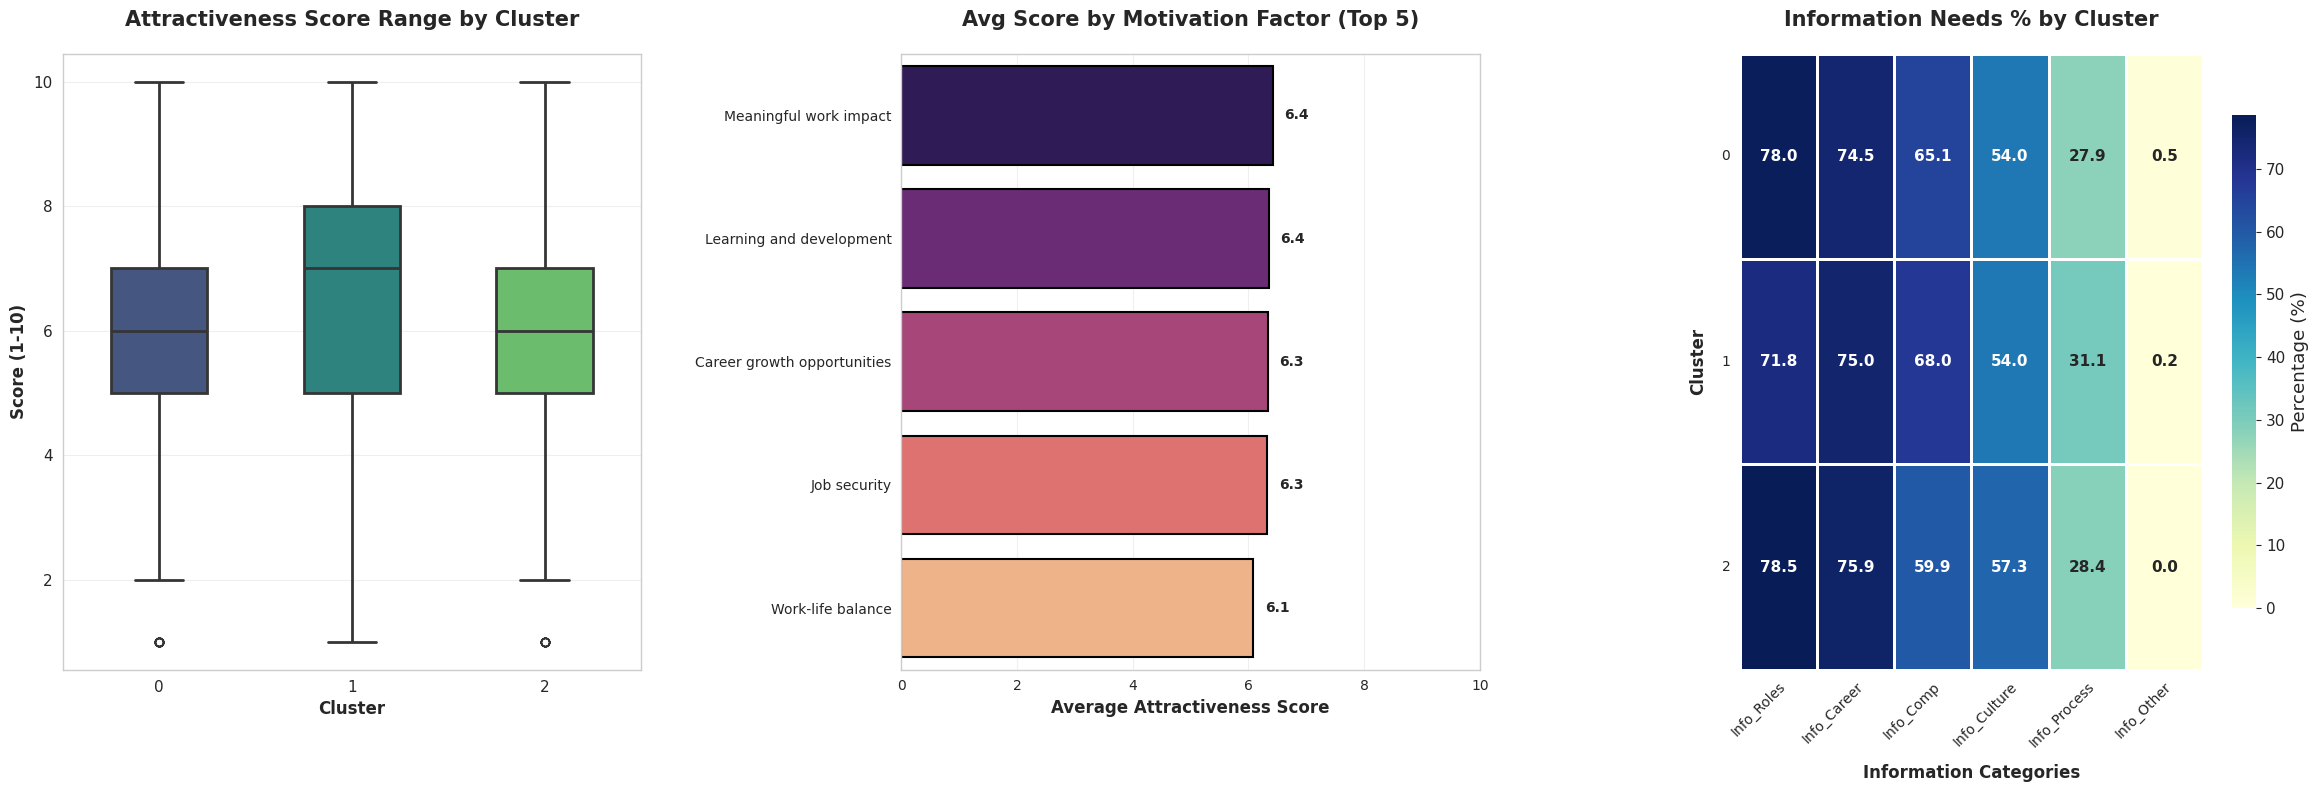

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# Create figure with more space
fig = plt.figure(figsize=(24, 8))

# Adjust spacing between subplots
plt.subplots_adjust(left=0.04, right=0.98, top=0.92, bottom=0.15, wspace=0.45)

# Plot 1: Box Plot - Attractiveness Score Range by Cluster
ax1 = plt.subplot(1, 3, 1)
sns.boxplot(data=work, x='Cluster', y='Attractiveness_Rating',
            palette='viridis', width=0.5, linewidth=2)
ax1.set_title('Attractiveness Score Range by Cluster', fontweight='bold', fontsize=15, pad=20)
ax1.set_ylabel('Score (1-10)', fontsize=12, fontweight='semibold')
ax1.set_xlabel('Cluster', fontsize=12, fontweight='semibold')
ax1.tick_params(labelsize=11)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Bar Chart - Motivation Factors
ax2 = plt.subplot(1, 3, 2)
bars = sns.barplot(x=motivator_impact.values, y=motivator_impact.index,
                   palette='magma', orient='h', edgecolor='black', linewidth=1.5)
ax2.set_xlim(0, 10)
ax2.set_title('Avg Score by Motivation Factor (Top 5)', fontweight='bold', fontsize=15, pad=20)
ax2.set_xlabel('Average Attractiveness Score', fontsize=12, fontweight='semibold')
ax2.set_ylabel('', fontsize=12, fontweight='semibold')  # Remove y-axis label
ax2.tick_params(labelsize=10)
ax2.grid(axis='x', alpha=0.3)
# Adjust y-axis labels to prevent overlap
plt.setp(ax2.get_yticklabels(), ha='right')

# Add value labels on bars
for i, bar in enumerate(bars.patches):
    width = bar.get_width()
    ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Plot 3: Heatmap - Information Needs
ax3 = plt.subplot(1, 3, 3)
sns.heatmap(cluster_info_needs, annot=True, cmap='YlGnBu', fmt='.1f',
            linewidths=2, linecolor='white', cbar_kws={'shrink': 0.8, 'label': 'Percentage (%)'},
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax3.set_title('Information Needs % by Cluster', fontweight='bold', fontsize=15, pad=20)
ax3.set_xlabel('Information Categories', fontsize=12, fontweight='semibold', labelpad=10)
ax3.set_ylabel('Cluster', fontsize=12, fontweight='semibold', labelpad=10)
ax3.tick_params(labelsize=10, rotation=0)

# Rotate x-axis labels for better readability
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('employer_attractiveness_insights.png', dpi=300, bbox_inches='tight')
plt.show()